# About This Notebook...............
------------------------------------+++++++++++++++-------------------------------                                         

# Section 1:                                                  
In this section we have loaded and imported datasets (products, items and user information and interactions) and libraries, We have performed some basics operations to understand the dataset. For better understanding and insights, we have perfromed anlysis (EDA) for users and items interaction by attractive plots and visualization

=============================+++==================                                         
# Section 2:                                                          

In our recommendation system framework, we have implemented a diverse set of recommendation approaches, each catering to distinct aspects of personalized recommendations. First and foremost, we have a rating-based approach that relies on user ratings and feedback to recommend items. This method is effective for providing recommendations to users based on their historical preferences and is a fundamental component of many recommendation systems. Additionally, we've incorporated a content-based approach that leverages item attributes and user profiles to suggest items with similar characteristics, making it particularly useful for addressing the cold start problem and recommending items that align with a user's specific interests and preferences.

In parallel, we've integrated collaborative filtering, a technique that analyzes user-item interactions and identifies patterns of user behavior, fostering the discovery of items that users with similar tastes have enjoyed. This approach enables users to discover items they might not have encountered otherwise and enhances recommendation diversity. Furthermore, our hybrid recommendation approach combines multiple methods, blending the strengths of rating-based, content-based, and collaborative filtering techniques to provide a more robust and accurate recommendation system.


# Step 0: Loading Packages and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing (Working With Users Interaction with Items)

In [2]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


# Basic Operations

In [4]:
train_data.shape # finding rows and cols

(5000, 10)

In [5]:
train_data.isnull().sum() # checking missing values

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [6]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

In [7]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [8]:
train_data.duplicated().sum()

0

In [9]:
train_data.drop_duplicates(inplace=True)

In [10]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}

# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [11]:
train_data.head(3)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5000 non-null   object 
 1   ProdID       5000 non-null   object 
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


In [13]:
# Clean 'ID' and 'ProdID' columns using regex
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5000 non-null   float64
 1   ProdID       5000 non-null   float64
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(4), object(6)
memory usage: 390.8+ KB


In [15]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [16]:
# Remove duplicate rows based on 'ID' and 'ProdID'
train_data = train_data.drop_duplicates(subset=['ID', 'ProdID'])

# Step 2: EDA (Exploratory Data Analysis)

In [17]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [18]:
train_data.shape

(4090, 10)

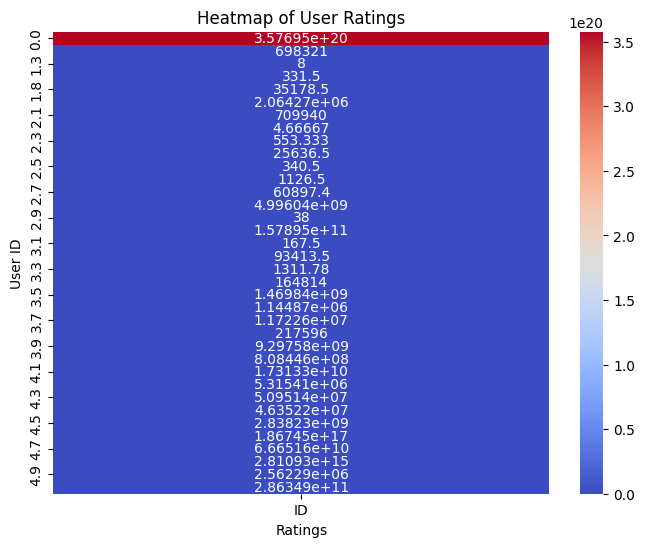

In [19]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

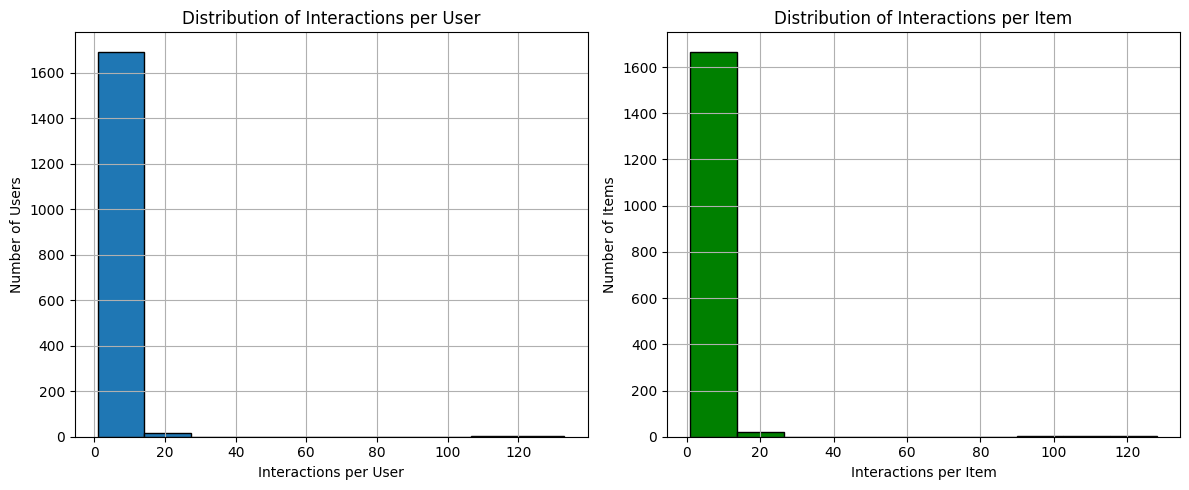

In [20]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

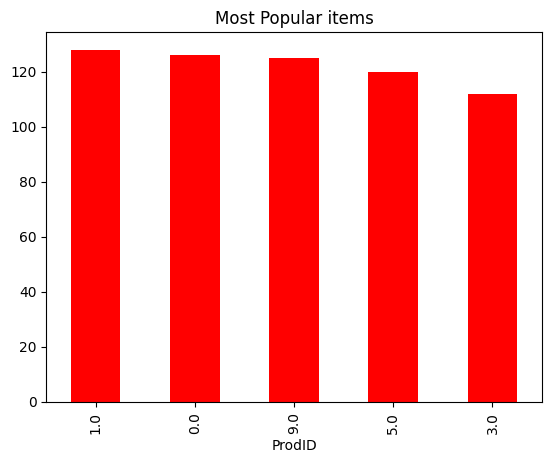

In [21]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

In [22]:
# User activity and item popularity
user_activity = train_data['ID'].value_counts()
item_popularity = train_data['ProdID'].value_counts()

<Axes: xlabel='Rating'>

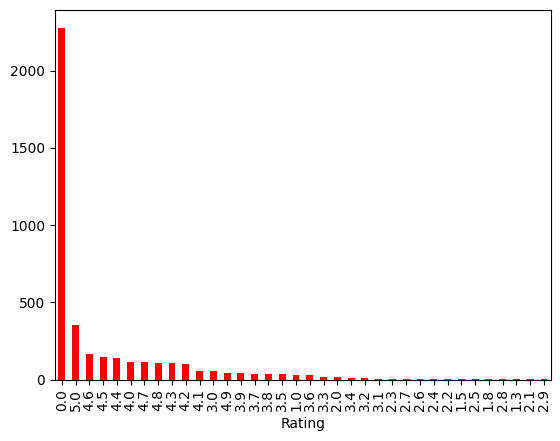

In [23]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')
# sns.countplot(x=train_data['Rating'])

# Step 2: Data cleaning and preprocessing

In [24]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")
def clean_and_extract_tags(text):
    doc = nlp(text.lower())

    # Filter out stop words, punctuation, and non-alphanumeric tokens
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]

    return ', '.join(tags)


columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
#     df[column] = df[column].fillna("")  # Replace NaN values with empty strings
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [25]:
# train_data.drop(['Category', 'Brand'],axis=1,inplace=True)
train_data['ID'] = train_data['ID'].astype(int)

In [26]:
train_data['ProdID'] = train_data['ProdID'].astype(int)
train_data.to_csv("clean_data.csv")
train_data.head(3)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792,2,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,95,76,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8,8,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."


# We are ready to jump into

# Step 3: Train different Recommendation models

In [27]:
from sklearn.model_selection import train_test_split

# Split the train_data into train and test sets
train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Ensure that all users and items in test_set are also in train_set
common_users = test_set['ID'].isin(train_set['ID'])
common_items = test_set['ProdID'].isin(train_set['ProdID'])
test_set = test_set[common_users & common_items]

# Check the shape of train and test sets
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)


Train set shape: (3272, 10)
Test set shape: (300, 10)


# Rating Base (Trending Products)
In this step, we'll generate recommendations based on item ratings. We'll recommend items with the highest average ratings.)

In [29]:
import warnings
import pandas as pd

# Ignore SettingWithCopyWarning
# warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# Group the data by item and calculate the average rating for each item
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

# Sort items by average rating in descending order to recommend top-rated items
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

# Recommend the top N items (e.g., top 10)
top_n = 10
rating_based_recommendations = top_rated_items.head(top_n)
rating_based_recommendations['Rating'] = rating_based_recommendations['Rating'].astype(int)
rating_based_recommendations['ReviewCount'] = rating_based_recommendations['ReviewCount'].astype(int)

# Display the rating-based recommendations
print("Rating-Based Recommendations:(trending products)")
rating_based_recommendations[['Name', 'Rating','ReviewCount','Brand','ImageURL']] = rating_based_recommendations[['Name', 'Rating','ReviewCount','Brand','ImageURL']]
# rating_based_recommendations.to_csv("models/trending_products.csv")

rating_based_recommendations


Rating-Based Recommendations:(trending products)


<ipython-input-29-3adf904dd118>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_based_recommendations['Rating'] = rating_based_recommendations['Rating'].astype(int)
<ipython-input-29-3adf904dd118>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_based_recommendations['ReviewCount'] = rating_based_recommendations['ReviewCount'].astype(int)
<ipython-input-29-3adf904dd118>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,Name,ReviewCount,Brand,ImageURL,Rating
2609,"Nicole by OPI Nail Lacquer, Next Stop the Biki...",1,opi,https://i5.walmartimages.com/asr/a3436bdc-e2e5...,5
3124,"R+Co Aircraft Pomade Mousse, 5.6 Oz",1,,https://i5.walmartimages.com/asr/03319cbe-7f61...,5
885,Candle Warmers Etc. Rustic Brown Hurricane Can...,10,"candle, warmers, etc",https://i5.walmartimages.com/asr/54376245-b5c1...,5
3140,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
3137,"ReNew Life CleanseMore, Veggie Caps, 60 ea",15,"renew, life",https://i5.walmartimages.com/asr/9f707fe4-9ee3...,5
436,Alba Botanica Very Emollient Herbal Healing Bo...,3,"alba, botanica",https://i5.walmartimages.com/asr/6050a2f0-3f91...,5
1704,"Groganics DHT Ice Oil Scalp Moisturizer, 4 oz",1,groganics,https://i5.walmartimages.com/asr/ed63df5f-b0a6...,5
3846,Vega Chlorella Dietary Supplement Powder 5.3 o...,1,vega,https://i5.walmartimages.com/asr/e8ddd649-4959...,5
1707,Guerlain L\homme Ideal Eau De Toilette Spray f...,1,guerlain,https://i5.walmartimages.com/asr/2f141245-7503...,5
428,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5


# Step 4: Content-Based Recommendations (Search Base)
In this step, we'll create content-based recommendations by analyzing item descriptions and features. We'll use text-based similarity measures to recommend items similar to a given item.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = linear_kernel(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [31]:
# Example: Get content-based recommendations for a specific item
item_name = 'The Art of Shaving Mens Hair Styling Gel, Juniper Scent, 2 Fl Oz'
content_based_rec = content_based_recommendations(train_data,item_name, top_n=10)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
1844,"American Crew Firm Hold Styling Hair Gel, 13.1...",2.0,"american, crew",https://i5.walmartimages.com/asr/7339f9d4-52ec...,5.0
2416,Axe Whatever Messy Look Paste Hair Styling Pom...,0.0,"axe, hair, care",https://i5.walmartimages.com/asr/728ab578-8769...,0.0
4340,"American Crew Forming Cream, 1.75 oz",1.0,"american, crew",https://i5.walmartimages.com/asr/bc677afe-f6e9...,0.0
1458,(29% Off Deal) Its a 10 Miracle Firm Hold Hair...,5.0,10,https://i5.walmartimages.com/asr/f9a73a70-4d0d...,5.0
1719,"(26% Off Deal) Its A 10 Miracle Styling Cream,...",9.0,10,https://i5.walmartimages.com/asr/987cc501-a4f8...,4.6
2858,Healing Solutions - Juniper Berry Oil (10ml) 1...,1.0,"healing, solutions",https://i5.walmartimages.com/asr/ca709f39-4dc0...,5.0
3320,The Art of Shaving Lexington Collection Handcr...,2.0,"art, shaving",https://i5.walmartimages.com/asr/c464dcfc-c433...,2.5
96,"Redken Mess Around 10 Disrupting Cream Paste, ...",10.0,redken,https://i5.walmartimages.com/asr/ccbff74f-b784...,0.0
2188,Redken Curvaceous Spiral Look High-Hold Hair G...,6.0,redken,https://i5.walmartimages.com/asr/99d48466-ffb2...,0.0
2835,No Blow Dry Nbd Just Right Cream - Medium Hair...,86.0,redken,https://i5.walmartimages.com/asr/41ab3cda-d3c3...,4.5


In [32]:
# Define ground truth relevance threshold (e.g., ratings >= 4)
relevance_threshold = 4

# Calculate precision and recall
relevant_items = content_based_rec[content_based_rec['Rating'] >= relevance_threshold]
precision = len(relevant_items) / len(content_based_rec)
recall = len(relevant_items) / len(train_data[train_data['Rating'] >= relevance_threshold])

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calculate coverage
total_items = len(train_data)
covered_items = len(content_based_rec)
coverage = covered_items / total_items

# Calculate diversity (e.g., using item features)
# Diversity could be measured as the average similarity between recommended items
# For simplicity, let's assume diversity is 1 - average similarity
average_similarity = 0  # You would need to compute this based on item features
diversity = 1 - average_similarity

# Calculate novelty (e.g., using popularity of recommended items)
# Novelty could be measured as the average popularity (e.g., number of ratings) of recommended items
# For simplicity, let's assume novelty is the average popularity score
average_popularity = content_based_rec['ReviewCount'].mean()
novelty = average_popularity

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Coverage:", coverage)
print("Diversity:", diversity)
print("Novelty:", novelty)


Precision: 0.5
Recall: 0.0034554250172771253
F1 Score: 0.0068634179821551134
Coverage: 0.0024449877750611247
Diversity: 1
Novelty: 12.2


# Step 5: Collaborative Filtering Recommendations
In this step, we'll implement collaborative filtering using matrix factorization techniques. We'll use the Surprise library for this purpose. Make sure to install the Surprise library if you haven't already (pip install scikit-surprise).

In [33]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

# Example usage
target_user_id = 4
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 10 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
24,Hempz Milk & Honey Herbal Body Moisturizer 2.2...,7.0,hempz,https://i5.walmartimages.com/asr/83e236e5-392c...,0.0
...,...,...,...,...,...
4950,"Great Value Everyday Paper Plates, 10&quot, 15...",131.0,"great, value",https://i5.walmartimages.com/asr/4f8ef540-3a40...,0.0
4957,Hibiclens 57508 Bottle 8 oz.,2.0,hibiclens,https://i5.walmartimages.com/asr/63b85475-d922...,0.0
4964,"TENA Regular Absorbency Day Pad, Blue-Pack of 46",0.0,"sca, personal, care",https://i5.walmartimages.com/asr/74750306-8afd...,0.0
4968,Zippered Pillow Cases Cover Pillowcases Egypti...,10.0,"unique, bargains",https://i5.walmartimages.com/asr/8d68b141-9d5b...,3.3


In [36]:
from sklearn.metrics import precision_score,recall_score,f1_score,mean_absolute_error,mean_squared_error

def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ID'] == target_user_id][['ProdID', 'Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

# Example usage
target_user_id = 4
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)

# Get the items that were recommended to the target user
recommended_item_ids = collaborative_filtering_rec['ProdID']

# Get the ground truth ratings for the target user
ground_truth_ratings = train_data[train_data['ID'] == target_user_id]

# Filter ground truth ratings to only include items that were recommended
ground_truth_ratings_recommended = ground_truth_ratings[ground_truth_ratings['ProdID'].isin(recommended_item_ids)]

# Extract the ratings and convert them to binary relevance based on the threshold
ground_truth_relevance = (ground_truth_ratings_recommended['Rating'] >= relevance_threshold).astype(int)

# Extract the predicted ratings for the recommended items
predicted_ratings = collaborative_filtering_rec['Rating']

# Convert predicted ratings to binary relevance based on the threshold
predicted_relevance = (predicted_ratings >= relevance_threshold).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(ground_truth_relevance, predicted_relevance)
recall = recall_score(ground_truth_relevance, predicted_relevance)
f1 = f1_score(ground_truth_relevance, predicted_relevance)

# Compute MAE and RMSE
mae = mean_absolute_error(ground_truth_ratings_recommended['Rating'], predicted_ratings)
rmse = mean_squared_error(ground_truth_ratings_recommended['Rating'], predicted_ratings, squared=False)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MAE:", mae)
print("RMSE:", rmse)


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE: 0.0
RMSE: 0.0


# Step 6: Hybrid Recommendations
In this step, we'll combine different recommendation approaches to create hybrid recommendations. We can use a weighted approach to combine ratings-based, content-based, and collaborative filtering recommendations.

In [37]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec

In [38]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating,ProdID
1865,Sally Hansen Miracle Gel Nail Color Polish Sma...,11132.0,"sally, hansen",https://i5.walmartimages.com/asr/dcac19a4-d67e...,4.2,NaN
3821,"Sally Hansen Hard as Nails Nail Polish, Unbrea...",0.0,"sally, hansen",https://i5.walmartimages.com/asr/fecff58e-f4b3...,0.0,NaN
599,Sally Hansen Triple Shine Nail Color 340 Scale...,0.0,"sally, hansen",https://i5.walmartimages.com/asr/adab37ef-3ef7...,0.0,NaN
1710,Sally Hansen Hard As Nails Xtreme Wear Nail Co...,1624.0,"sally, hansen",https://i5.walmartimages.com/asr/9f8f16d1-f2f2...,4.2,NaN
2918,"Sally Hansen Miracle Gel Nail Polish, Terra-Co...",11334.0,"sally, hansen",https://i5.walmartimages.com/asr/acb03bbb-fa57...,0.0,NaN
...,...,...,...,...,...,...
4828,Mac Keepsakes/Plum Eyes Palette 0.112oz/3.2g N...,0.0,mac,https://i5.walmartimages.com/asr/ca90455c-c005...,0.0,985.0
4854,"OPI Infinite Shine Nail Polish, Dulce De Leche...",1.0,opi,https://i5.walmartimages.com/asr/466527fe-9e5e...,5.0,84.0
4876,GOJO Fast Towels - 225 Count Bucket,0.0,gojo,https://i5.walmartimages.com/asr/ac84dbbe-77ff...,0.0,14.0
4894,(5 Pack) Glade PlugIns Car Air Freshener Refil...,63.0,glade,https://i5.walmartimages.com/asr/06b67413-ca39...,4.1,626.0


# Step 8: Multi-Model Recommendation
In this step, we'll combine the results from various recommendation models to provide diverse recommendations. We can use a voting mechanism to select the final recommendations.

In [39]:
from collections import Counter

# Combine recommendations from different models into a single list
all_recommendations = [
    rating_based_recommendations,
    content_based_rec,
    collaborative_filtering_rec,
    hybrid_rec,
]

# Perform voting to select the final recommendations
final_recommendations = []
for recommendations in zip(*all_recommendations):
    # Use Counter to count the occurrences of each item in recommendations
    item_counts = Counter(recommendations)

    # Select the top 5 most common items as the final recommendations
    final_recommendations.append(item_counts.most_common(10))

# Display the final multi-model recommendations
print("Multi-Model Recommendations:")
# Iterate through the nested lists and print each sentence on a new line
for rec_set in final_recommendations:
    i = 1
    for item_name, count in rec_set:
        print(i , f"{item_name}: {count}")
        i +=1

    print()  # Print an empty line between sets of recommendations

Multi-Model Recommendations:
1 Name: 3
2 ProdID: 1

1 ReviewCount: 3
2 Name: 1

1 Brand: 3
2 ReviewCount: 1

1 ImageURL: 3
2 Brand: 1

1 Rating: 3
2 ImageURL: 1

